📘 Jupyter Notebook: Comparinmg different noise methods

In [1]:
# 📦 Section 1: Imports & Setup
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from grid_reducer.opendss import OpenDSS
from grid_reducer.network import get_graph_from_circuit
from grid_reducer.plot import graph_to_geo_dataframe
from grid_reducer.add_differential_privacy import (
    LowPrivacyConfig,
    MediumPrivacyConfig,
    HighPrivacyConfig,
    evaluate_dp_methods_on_circuit
)

In [2]:
# ⚡ Section 2: Load and Parse OpenDSS Circuit

# master_dss_path = Path("../tests/extra_data/P12U/scenarios/base_timeseries/opendss/p12uhs0_1247/p12uhs0_1247--p12udt1271/Master.dss")
master_dss_path = Path("../tests/data/smartds/Master.dss")

# Load the circuit object from the OpenDSS model
ckt = OpenDSS(master_dss_path).get_circuit()

In [3]:
def dbscan_elbow_plot(circuit, min_samples=2):
    coords = [
        (bus.X, bus.Y)
        for bus in circuit.Bus
        if bus.X is not None and bus.Y is not None
    ]
    X = np.array(coords)
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, min_samples - 1])
    plt.figure(figsize=(8,5))
    plt.plot(k_distances)
    plt.xlabel("Sorted Points")
    plt.ylabel(f"Distance to {min_samples}-th NN")
    plt.title("DBSCAN eps Selection Elbow Plot")
    plt.grid(True)
    plt.show()
    return k_distances

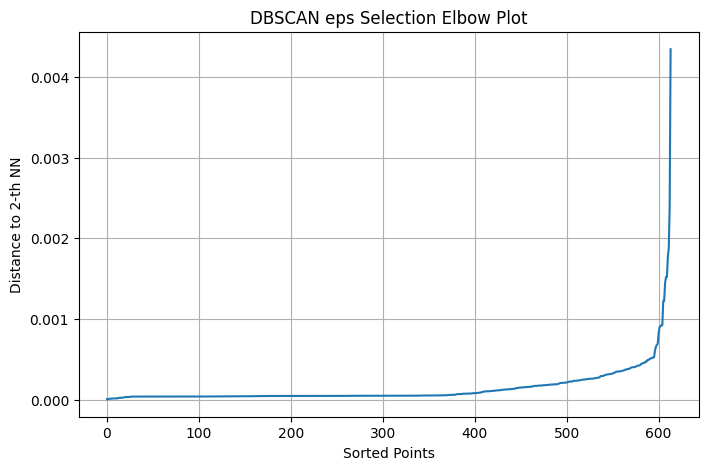

array([9.64471029e-06, 9.64471029e-06, 1.46178110e-05, 1.46178110e-05,
       1.63714400e-05, 1.63714400e-05, 1.83594437e-05, 1.83594437e-05,
       1.96935392e-05, 1.96935392e-05, 1.98342607e-05, 1.98342607e-05,
       2.45356011e-05, 2.45356011e-05, 2.75769717e-05, 2.75769717e-05,
       2.82994558e-05, 2.82994558e-05, 3.11176464e-05, 3.54069949e-05,
       3.54069949e-05, 3.70810799e-05, 3.70810799e-05, 3.71342700e-05,
       3.71342700e-05, 3.73162465e-05, 4.23022371e-05, 4.23022371e-05,
       4.23029501e-05, 4.23029501e-05, 4.23213323e-05, 4.23213323e-05,
       4.23215094e-05, 4.23215094e-05, 4.23242300e-05, 4.23648112e-05,
       4.23903972e-05, 4.23903972e-05, 4.24356107e-05, 4.24356107e-05,
       4.24358078e-05, 4.24358078e-05, 4.24362030e-05, 4.24364798e-05,
       4.24364798e-05, 4.24373135e-05, 4.24373135e-05, 4.24373406e-05,
       4.24373406e-05, 4.24374419e-05, 4.24374419e-05, 4.24375211e-05,
       4.24375211e-05, 4.24375516e-05, 4.24375516e-05, 4.24375740e-05,
      

In [4]:
# Elbow plot to help select eps for DBSCAN
dbscan_elbow_plot(ckt, min_samples=2)

In [5]:
eval_stats = evaluate_dp_methods_on_circuit(
    ckt,
    LowPrivacyConfig(),           # or which config you want
    cluster_eps=0.0011,           # optimal eps from elbow plot
    min_samples=2,        
    #adaptive_params=dict(base_epsilon=5000, min_epsilon=1000, max_epsilon=7000, neighbor_radius=0.01)
    adaptive_params=dict(base_epsilon=3500, min_epsilon=2000, max_epsilon=5000, neighbor_radius=0.01)
)

In [6]:
print("Planar Laplace mean loss:", eval_stats['planar_mean_loss'])
print("Cluster-Based mean loss:", eval_stats['cluster_mean_loss'])
print("Adaptive mean loss:", eval_stats['adaptive_mean_loss'])

Planar Laplace mean loss: 41.19046060705492
Cluster-Based mean loss: 109.67757172308079
Adaptive mean loss: 43.39638101162256


In [7]:
graph0 = get_graph_from_circuit(ckt)
gdf0 = graph_to_geo_dataframe(graph0)
graph1 = get_graph_from_circuit(eval_stats['planar_circuit'])
gdf1 = graph_to_geo_dataframe(graph1)
graph2 = get_graph_from_circuit(eval_stats['cluster_circuit'])
gdf2 = graph_to_geo_dataframe(graph2)
graph3 = get_graph_from_circuit(eval_stats['adaptive_circuit'])
gdf3 = graph_to_geo_dataframe(graph3)


In [8]:
gdf0["source"] = "Original"
gdf1["source"] = "Planar Method"
gdf2["source"] = "Cluster Method"
gdf3["source"] = "Adaptive Noise Scaling"


In [9]:
combined_gdf = pd.concat([gdf0, gdf1, gdf2, gdf3], ignore_index=True)

m = combined_gdf.explore(
    column="source",
    legend=True,
    cmap="Set1",
    style_kwds={
        "weight": 5,  # Line width
        "opacity": 0.8,  # Line transparency (optional)
    }
)
#m.save("combined_map.html")
m

In [10]:
combined_gdf1 = pd.concat([gdf0, gdf1], ignore_index=True)

m1 = combined_gdf1.explore(
    column="source",
    legend=True,
    cmap="Set1",
    style_kwds={
        "weight": 5,  # Line width
        "opacity": 0.8,  # Line transparency (optional)
    }
)
#m.save("combined_map.html")
m1

In [11]:
combined_gdf2 = pd.concat([gdf0, gdf2], ignore_index=True)

m2 = combined_gdf2.explore(
    column="source",
    legend=True,
    cmap="Set1",
    style_kwds={
        "weight": 5,  # Line width
        "opacity": 0.8,  # Line transparency (optional)
    }
)
#m.save("combined_map.html")
m2

In [ ]:
combined_gdf3 = pd.concat([gdf0, gdf3], ignore_index=True)
m3 = combined_gdf3.explore(
    column="source",
    legend=True,
    cmap="Set1",
    style_kwds={
        "weight": 5,  # Line width
        "opacity": 0.8,  # Line transparency (optional)
    }
)
#m.save("combined_map.html")
m3

### Conclusion: 

#### Different Methods Tested
- Planar Laplace simply adds random noise to each bus coordinate using the same privacy strength (epsilon) everywhere, ensuring a consistent and formal privacy guarantee.

- Cluster-based first finds clusters of buses, adds noise to each cluster’s centroid, and then assigns the same noisy centroid location to all buses in that cluster.

- Adaptive Noise Scaling is like Planar Laplace, but varies the amount of noise: it adds less noise in dense regions and more in sparse regions (local density). In our case, the grid circuit doesn’t naturally have both urban and rural parts, so adaptive scaling ends up using locally-calculated density, creating strange clumping or distorted lines in some areas.

The cluster-based method does not work well—even with the optimal eps from the elbow plot—because the resulting map shows large distortions and high loss compared to the Planar Laplace method. Adaptive Noise Scaling produces similar losses (to Planar Laplace methiod) but also creates visually odd groupings and artifacts on the map that don’t look like grid lines.


Therefore, the Planar Laplace method is the best choice for our code—its results are most faithful to the true grid and offer strong, simple privacy protection.